<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction</b> </p>
SRN:PES2UG20CS275           NAME:RITVIK WUYYURRU <br/>
SRN:PES2UG20CS279           NAME:ROBIN ROY <br/>
SRN:PES2UG20CS284           NAME:RONIT BHATHIJA <br/>
SRN:PES2UG20CS298           NAME:SAIEESH S RAO <br/>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data set
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting
data contains two columns source and destination eac edge in graph - Data columns (total 2 columns):
- source_node int64
- destination_node int64

### LIBRARIES USED:

- pandas
- csv
- datetime
- numpy
- matplotlib
- sklearn
- seaborn
- pickle
- os
- xgboost
- networkx
- tqdm
- scipy
- collections
- random




In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

we have been given train.csv with 2 columns source_node , destination_node

In [3]:
#reading graph
if not os.path.isfile('/kaggle/working/train_woheader.csv'):
    traincsv = pd.read_csv('/kaggle/input/FacebookRecruiting/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/kaggle/working/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/kaggle/working/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


> Displaying a sub graph

# 1. Exploratory Data Analysis

In [4]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


## 1.1 No of followers for each person

The number of followers is exactly equal to in degree

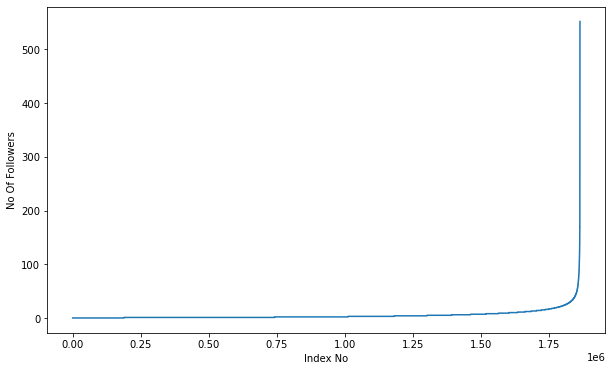

In [5]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

Let us zoom in a bit as there are millions of users squashed. So it is hard noticing vividly.

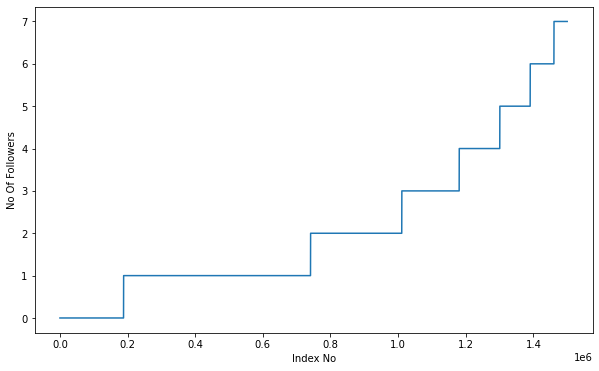

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

boxplot

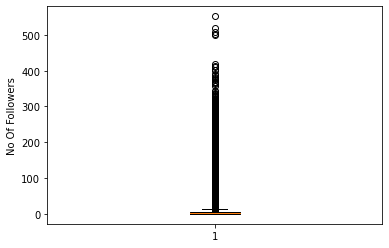

In [7]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

We see that most users have 1 or very few followers. The plot shows outliers.

In [8]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


We can observe that 90% of the users have followers of less than 12. 99% of the users have followers less than 40 or fewer. There is one user with 552 followers.

99% of data having followers of 40 only.

In [9]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


Let’s zoom in from the 99th percentile to the 100th percentile. Only 0.1% of users have more than 112 followers.

## 1.2 No of people each person is following

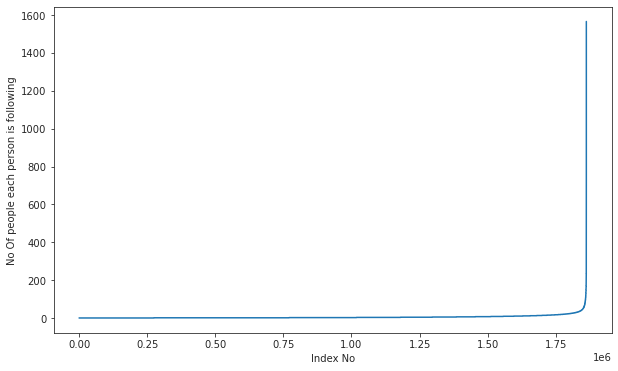

In [11]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

Let’s zoom in on the graph from 0th users to 1.5 million users

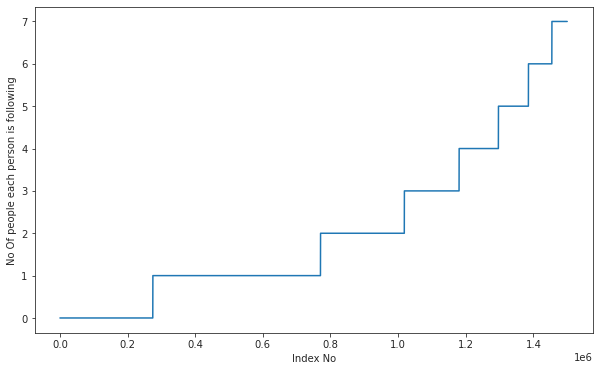

In [12]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

We can observe from the graph that around 1.5 million users follow less than 7 people.

boxplot

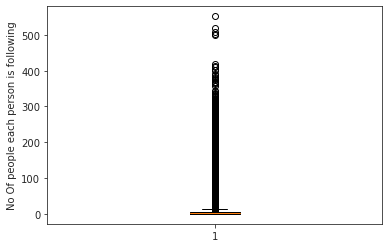

In [13]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

There are fewer outliers. The number of people following is lesser.

In [14]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


One person is following 1566 people, and 99 percentile people are following less than 40 people.

In [15]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


99.9 % of people are following less than 123 people.

In [17]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [18]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [19]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 1.3 both followers + following 

The same analysis can be performed for both (followers+following). degree(Ui) = In_degree(Ui) + Out_degree(Ui)

In [20]:
from collections import Counter
dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

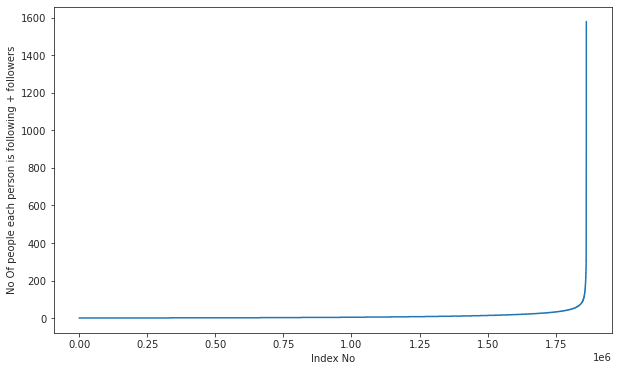

In [21]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

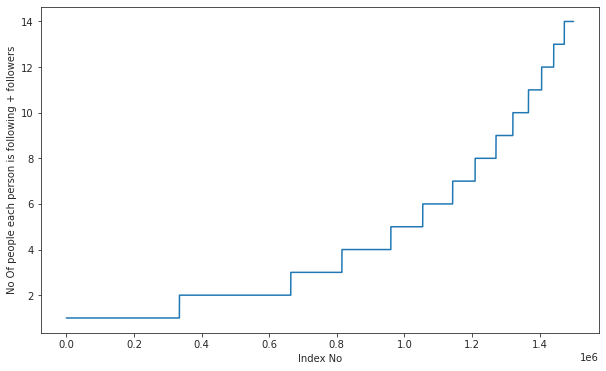

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [23]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [24]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [25]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [26]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [27]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [28]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

We want to convert this problem into a binary classification problem such that existing labels are classified as “1” and non-existing edges are classified as “0”.

We need to generate data for the label “0”. But for each vertex, we will have an (n-1) edge. For all edges, we will have n x (n-1) edges which will be very large so we will randomly sample 100000 edges out of total possible edges

In [29]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('/kaggle/working/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/kaggle/working/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<100000):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/kaggle/working/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('/kaggle/working/missing_edges_final.p','rb'))

CPU times: user 3min 4s, sys: 2.16 s, total: 3min 6s
Wall time: 3min 6s


In [30]:
len(missing_edges)

100000

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

We split the data into an 80:20 ratio.
We split positive and negative links separately because we only need positive training data to create graphs and feature generation.
For positive links : X_train_pos, X_test_pos, y_train_pos, y_test_pos
For negative links: X_train_neg, X_test_neg, y_train_neg, y_test_neg

In [31]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and (not os.path.isfile('/kaggle/working/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('/kaggle/input/FacebookRecruiting/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('/kaggle/working/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('/kaggle/working/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('/kaggle/working/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('/kaggle/working/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 100000
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 80000 = 80000
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 20000 = 20000


Now, we appended X_train_neg to X_train_pos.
We concatenated (y_train_pos,y_train_neg).
We appended X_test_neg to X_test_pos.
We concatenated (y_test_pos,y_test_neg).

In [32]:
if (os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and (os.path.isfile('/kaggle/working/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('/kaggle/working/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('/kaggle/working/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [33]:
#final train and test data sets
if (not os.path.isfile('/kaggle/working/train_after_eda.csv')) and \
(not os.path.isfile('/kaggle/working/test_after_eda.csv')) and \
(not os.path.isfile('/kaggle/working/train_y.csv')) and \
(not os.path.isfile('/kaggle/working/test_y.csv')) and \
(os.path.isfile('/kaggle/working/train_pos_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/test_pos_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/train_neg_after_eda.csv')) and \
(os.path.isfile('/kaggle/working/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('/kaggle/working/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('/kaggle/working/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('/kaggle/working/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('/kaggle/working/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('/kaggle/working/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('/kaggle/working/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('/kaggle/working/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('/kaggle/working/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 80000
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 20000


In [34]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (7630015, 2)
Data points in test data (1907504, 2)
Shape of traget variable in train (7630015,)
Shape of traget variable in test (1907504,)


FEATURIZATION

In [35]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

In [37]:
if os.path.isfile('/kaggle/working/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/kaggle/working/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# 2. Similarity measures

## 2.1 Jaccard Distance:


\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and distinct. It’s a measure of similarity for the two sets of data, ranging from 0% to 100%. The higher the percentage, the more similar the two populations.

In [38]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [39]:
#one test case
print(jaccard_for_followees(273084,1505602))

0.0


In [40]:
#node 1635354 not in graph 
print(jaccard_for_followees(273084,1505602))

0.0


In [41]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [42]:
print(jaccard_for_followers(273084,470294))

0.0


In [43]:
#node 1635354 not in graph 
print(jaccard_for_followees(669354,1635354))

0


## 2.2 Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

Which is used when X and Y are vectors. But, we will use a simple extension to cosine distance, which is Otsuka Ochiai Coefficient.

Otsuka-Ochiai coefficient is used when X and Y are set

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{sqrt(|X|\cdot|y|)}
\end{equation}

In [44]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [45]:
print(cosine_for_followees(273084,1505602))

0.0


In [46]:
print(cosine_for_followees(273084,1635354))

0


In [47]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [48]:
print(cosine_for_followers(2,470294))

0.02886751345948129


In [49]:
print(cosine_for_followers(669354,1635354))

0


## 3. Ranking Measures

## 3.1 Page Ranking

PageRank is a very, very popular featurization technique for directed graphs
It is an algorithm used by google search to rank web pages in their search engine results.
It is a way of measuring the importance of website pages.
PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the page is.
If many pages have a destination as “B,” then “B” must be important.
and
If my page “B” is given as a link in many important pages like C, E, D, etc., the “B” page value increases.

PageRank can tell us about relative importance.


In [51]:
if not os.path.isfile('/kaggle/working/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('/kaggle/working/page_rank.p','wb'))
else:
    pr = pickle.load(open('/kaggle/working/page_rank.p','rb'))

In [52]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [53]:
#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


# 4. Other Graph Features

## 4.1 Shortest path:

We can compute the shortest path between two-element. If nodes have a direct path, i.e., directly connected, we remove that edge and calculate the path.

If there is no edge between two vertices, we will consider the default value “-1”.
Suppose we have an edge between 2 vertices, whose shortest path is of length ‘1’, which makes no sense. In that case, we will remove that edge and calculate the shortest path between those two vertices.
The shortest path measures how far two vertices are at the least.

In [54]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [55]:
#testing
compute_shortest_path_length(77697, 826021)

10

In [56]:
#testing
compute_shortest_path_length(669354,1635354)

-1

## 4.2 Checking for same community

First, we are checking if there is a direct edge from b to a. If yes, we are checking to do both b, and a belong to the same wcc or community.
If yes, we removed the direct edge from b to a and calculated the shortest path from b to a. If the shortest path does not exist, then we declare that they are not in the same wcc/community even though they belong to the same wcc/community.
However, if there exists a shortest path from b to a, then it means they could be friends and hence we are declaring them in wcc/community.
Secondly, we check if there is a direct edge from a to b and follow the same approach as above and return 1 or 0.
If there is no direct edge from s to d or from d to s at the first place, then we are simply checking whether they belong to the same wcc. If yes, then just return 1 else 0.

In [57]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [58]:
belongs_to_same_wcc(861, 1659750)

0

In [59]:
belongs_to_same_wcc(669354,1635354)

0

## 4.3 Adamic/Adar Index:
Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [60]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [61]:
calc_adar_in(1,189226)

0

In [62]:
calc_adar_in(669354,1635354)

0

## 4.4 Does the person follow back:

In [63]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [64]:
follows_back(1,189226)

1

In [65]:
follows_back(669354,1635354)

0

## 4.5 Katz Centrality:
https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [66]:
if not os.path.isfile('/kaggle/working/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('/kaggle/working/katz.p','wb'))
else:
    katz = pickle.load(open('/kaggle/working/katz.p','rb'))

In [67]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [68]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


# 5. Featurization

## 5. 1 Reading a sample of Data from both train and test

In [72]:
import random
if os.path.isfile('/kaggle/working/train_after_eda.csv'):
    filename = "/kaggle/working/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

In [73]:
if os.path.isfile('/kaggle/working/train_after_eda.csv'):
    filename = "/kaggle/working/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [74]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


In [75]:
df_final_train = pd.read_csv('/kaggle/working/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('/kaggle/working/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (50486, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,438469,1286875,1


In [76]:
df_final_test = pd.read_csv('/kaggle/working/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('/kaggle/working/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (25268, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,557644,1022502,1


## 5.2 Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [77]:
if not os.path.isfile('/kaggle/working/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [78]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [79]:
if not os.path.isfile('/kaggle/working/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('/kaggle/working/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/kaggle/working/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/kaggle/working/storage_sample_stage1.h5', 'test_df',mode='r')

## 5.3 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

In [80]:
if not os.path.isfile('/kaggle/working/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('/kaggle/working/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/kaggle/working/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/kaggle/working/storage_sample_stage2.h5', 'test_df',mode='r')

## 5.4 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>

#### Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 
`credit` - Graph-based Features for Supervised Link Prediction
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

it is directed graph so calculated Weighted in and Weighted out differently

In [81]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:17<00:00, 100010.16it/s]


In [82]:
if not os.path.isfile('/kaggle/working/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [84]:
if not os.path.isfile('/kaggle/working/storage_sample_stage3.h5'):
    
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

#     #Hits algorithm score for source and destination in Train and test
#     #if anything not there in train graph then adding 0
#     df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
#     df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

#     df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
#     df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#     #================================================================================

#     #Hits algorithm score for source and destination in Train and Test
#     #if anything not there in train graph then adding 0
#     df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
#     df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

#     df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
#     df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('/kaggle/working/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/kaggle/working/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/kaggle/working/storage_sample_stage3.h5', 'test_df',mode='r')

In [86]:
#for train dataset
num_fs=np.array(df_final_train['num_followers_s'])
num_fd=np.array(df_final_train['num_followers_d'])
preferential_followers=[]
for i in range(len(num_fs)):
    preferential_followers.append(num_fd[i]*num_fs[i])
df_final_train['prefer_Attach_followers']= preferential_followers
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,prefer_Attach_followers
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,...,0.250000,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,66
1,438469,1286875,1,0.000000,0.000000,0.000000,0.000000,0,13,1,...,1.000000,1.277350,0.277350,1.554700,2.277350,1.655650e-07,2.811078e-06,0.000731,0.000780,0
2,1325247,760242,1,0.702703,0.369565,0.156957,0.566038,35,28,41,...,0.154303,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,980
3,101504,1691337,1,0.086957,0.117647,0.022388,0.211702,16,134,63,...,0.125000,0.211066,0.010758,0.297133,0.336066,3.045978e-07,1.467966e-06,0.000806,0.001394,2144
4,959250,1189845,1,0.000000,0.400000,0.000000,0.577350,3,2,4,...,0.447214,1.024564,0.258199,1.601914,1.471777,6.826773e-07,4.042322e-07,0.000742,0.000739,6


In [87]:
#for test dataset
num_fs=np.array(df_final_test['num_followers_s'])
num_fd=np.array(df_final_test['num_followers_d'])
preferential_followers=[]
for i in range(len(num_fs)):
    preferential_followers.append(num_fd[i]*num_fs[i])
df_final_test['prefer_Attach_followers']= preferential_followers
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,prefer_Attach_followers
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,...,0.377964,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,84
1,557644,1022502,1,0.350000,0.173913,0.101760,0.296500,28,26,28,...,0.185695,0.378145,0.035737,0.570596,0.563841,1.525963e-06,1.311142e-06,0.000846,0.000839,728
2,1048347,1531733,1,0.257042,0.300000,0.028120,0.482130,121,236,134,...,0.086066,0.151023,0.005591,0.215980,0.237090,6.820908e-07,1.068287e-06,0.001611,0.002823,28556
3,1262482,516631,1,0.066667,0.083333,0.092450,0.158114,13,3,8,...,0.333333,0.833333,0.166667,1.333333,1.166667,1.777137e-06,3.843433e-07,0.000781,0.000743,39
4,595979,372025,1,0.257812,0.308550,0.030206,0.476038,85,237,152,...,0.080845,0.145666,0.005240,0.210486,0.226511,4.333519e-07,1.067458e-06,0.001545,0.002923,20145


In [91]:
#for train dataset
num_fs=np.array(df_final_train['num_followees_s'])
num_fd=np.array(df_final_train['num_followees_d'])
preferential_followees=[]
for i in range(len(num_fs)):
    preferential_followees.append(num_fd[i]*num_fs[i])
df_final_train['prefer_Attach_followees']= preferential_followees
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,prefer_Attach_followers,prefer_Attach_followees
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,...,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,66,120
1,438469,1286875,1,0.000000,0.000000,0.000000,0.000000,0,13,1,...,1.277350,0.277350,1.554700,2.277350,1.655650e-07,2.811078e-06,0.000731,0.000780,0,0
2,1325247,760242,1,0.702703,0.369565,0.156957,0.566038,35,28,41,...,0.339999,0.028653,0.525694,0.494302,6.211019e-07,5.179801e-07,0.000885,0.000855,980,902
3,101504,1691337,1,0.086957,0.117647,0.022388,0.211702,16,134,63,...,0.211066,0.010758,0.297133,0.336066,3.045978e-07,1.467966e-06,0.000806,0.001394,2144,3213
4,959250,1189845,1,0.000000,0.400000,0.000000,0.577350,3,2,4,...,1.024564,0.258199,1.601914,1.471777,6.826773e-07,4.042322e-07,0.000742,0.000739,6,12


In [92]:
#for test dataset
num_fs=np.array(df_final_test['num_followees_s'])
num_fd=np.array(df_final_test['num_followees_d'])
preferential_followees=[]
for i in range(len(num_fs)):
    preferential_followees.append(num_fd[i]*num_fs[i])
df_final_test['prefer_Attach_followees']= preferential_followees
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,prefer_Attach_followers,prefer_Attach_followees
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,...,0.636163,0.097590,0.894362,1.014128,6.557971e-07,1.559547e-06,0.000754,0.000786,84,54
1,557644,1022502,1,0.350000,0.173913,0.101760,0.296500,28,26,28,...,0.378145,0.035737,0.570596,0.563841,1.525963e-06,1.311142e-06,0.000846,0.000839,728,728
2,1048347,1531733,1,0.257042,0.300000,0.028120,0.482130,121,236,134,...,0.151023,0.005591,0.215980,0.237090,6.820908e-07,1.068287e-06,0.001611,0.002823,28556,32562
3,1262482,516631,1,0.066667,0.083333,0.092450,0.158114,13,3,8,...,0.833333,0.166667,1.333333,1.166667,1.777137e-06,3.843433e-07,0.000781,0.000743,39,40
4,595979,372025,1,0.257812,0.308550,0.030206,0.476038,85,237,152,...,0.145666,0.005240,0.210486,0.226511,4.333519e-07,1.067458e-06,0.001545,0.002923,20145,30400


## 5.5 Adding new set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>SVD features for both source and destination</li>
</ol>

In [93]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [94]:
#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [95]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [96]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [97]:
if not os.path.isfile('/kaggle/working/storage_sample_stage4.h5'):
    
    
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    
   # hdf = HDFStore('/Users/mohdsaquib/downloads/FB/data/fea_sample/storage_sample_stage4.h5')
   # hdf.put('train_df',df_final_train, format='table', data_columns=True)
   # hdf.put('test_df',df_final_test, format='table', data_columns=True)
   # hdf.close()

In [98]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,...,1.983705e-06,1.545080e-13,8.108359e-13,1.719703e-14,-1.355368e-12,4.675134e-13,1.128588e-06,6.616659e-14,9.771063e-13,4.160009e-14
1,438469,1286875,1,0.000000,0.000000,0.000000,0.000000,0,13,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.132500e-12,1.025888e-11,4.420851e-11,3.019624e-12,9.833889e-13,3.864960e-14
2,1325247,760242,1,0.702703,0.369565,0.156957,0.566038,35,28,41,...,3.411866e-19,7.871936e-19,-1.390014e-19,-5.832537e-19,8.055188e-19,-5.823289e-20,2.679040e-19,6.634561e-19,-1.222407e-19,-4.825231e-19
3,101504,1691337,1,0.086957,0.117647,0.022388,0.211702,16,134,63,...,3.559874e-11,5.990778e-12,3.867730e-08,2.467904e-15,1.937359e-11,2.542083e-02,4.415101e-10,5.275977e-11,3.719295e-07,1.777319e-14
4,959250,1189845,1,0.000000,0.400000,0.000000,0.577350,3,2,4,...,2.236475e-15,5.229149e-17,9.903777e-18,1.245356e-18,-1.018578e-16,7.849903e-17,4.014487e-15,6.108958e-17,1.831893e-17,1.271613e-18


In [99]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'prefer_Attach_followers', 'prefer_Attach_followees',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [100]:
#for train datasets
s1,s2,s3,s4,s5,s6=df_final_train['svd_u_s_1'],df_final_train['svd_u_s_2'],df_final_train['svd_u_s_3'],df_final_train['svd_u_s_4'],df_final_train['svd_u_s_5'],df_final_train['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_train['svd_v_s_1'],df_final_train['svd_v_s_2'],df_final_train['svd_v_s_3'],df_final_train['svd_v_s_4'],df_final_train['svd_v_s_5'],df_final_train['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_train['svd_u_d_1'],df_final_train['svd_u_d_2'],df_final_train['svd_u_d_3'],df_final_train['svd_u_d_4'],df_final_train['svd_u_d_5'],df_final_train['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_train['svd_v_d_1'],df_final_train['svd_v_d_2'],df_final_train['svd_v_d_3'],df_final_train['svd_v_d_4'],df_final_train['svd_v_d_5'],df_final_train['svd_v_d_6']

In [101]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_train['svd_dot']=svd_dot

In [102]:
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,273084,1505602,1,0.000000,0.000000,0.000000,0.000000,11,6,15,...,1.545080e-13,8.108359e-13,1.719703e-14,-1.355368e-12,4.675134e-13,1.128588e-06,6.616659e-14,9.771063e-13,4.160009e-14,1.338797e-11
1,438469,1286875,1,0.000000,0.000000,0.000000,0.000000,0,13,1,...,0.000000e+00,0.000000e+00,0.000000e+00,-1.132500e-12,1.025888e-11,4.420851e-11,3.019624e-12,9.833889e-13,3.864960e-14,9.873487e-39
2,1325247,760242,1,0.702703,0.369565,0.156957,0.566038,35,28,41,...,7.871936e-19,-1.390014e-19,-5.832537e-19,8.055188e-19,-5.823289e-20,2.679040e-19,6.634561e-19,-1.222407e-19,-4.825231e-19,1.639333e-35
3,101504,1691337,1,0.086957,0.117647,0.022388,0.211702,16,134,63,...,5.990778e-12,3.867730e-08,2.467904e-15,1.937359e-11,2.542083e-02,4.415101e-10,5.275977e-11,3.719295e-07,1.777319e-14,2.715398e-04
4,959250,1189845,1,0.000000,0.400000,0.000000,0.577350,3,2,4,...,5.229149e-17,9.903777e-18,1.245356e-18,-1.018578e-16,7.849903e-17,4.014487e-15,6.108958e-17,1.831893e-17,1.271613e-18,1.331340e-26


In [103]:

#for test dataset
s1,s2,s3,s4,s5,s6=df_final_test['svd_u_s_1'],df_final_test['svd_u_s_2'],df_final_test['svd_u_s_3'],df_final_test['svd_u_s_4'],df_final_test['svd_u_s_5'],df_final_test['svd_u_s_6']
s7,s8,s9,s10,s11,s12=df_final_test['svd_v_s_1'],df_final_test['svd_v_s_2'],df_final_test['svd_v_s_3'],df_final_test['svd_v_s_4'],df_final_test['svd_v_s_5'],df_final_test['svd_v_s_6']

d1,d2,d3,d4,d5,d6=df_final_test['svd_u_d_1'],df_final_test['svd_u_d_2'],df_final_test['svd_u_d_3'],df_final_test['svd_u_d_4'],df_final_test['svd_u_d_5'],df_final_test['svd_u_d_6']
d7,d8,d9,d10,d11,d12=df_final_test['svd_v_d_1'],df_final_test['svd_v_d_2'],df_final_test['svd_v_d_3'],df_final_test['svd_v_d_4'],df_final_test['svd_v_d_5'],df_final_test['svd_v_d_6']

In [104]:
svd_dot=[]
for i in range(len(np.array(s1))):
    a=[]
    b=[]
    a.append(np.array(s1[i]))
    a.append(np.array(s2[i]))
    a.append(np.array(s3[i]))
    a.append(np.array(s4[i]))
    a.append(np.array(s5[i]))
    a.append(np.array(s6[i]))
    a.append(np.array(s7[i]))
    a.append(np.array(s8[i]))
    a.append(np.array(s9[i]))
    a.append(np.array(s10[i]))
    a.append(np.array(s11[i]))
    a.append(np.array(s12[i]))
    b.append(np.array(d1[i]))
    b.append(np.array(d2[i]))
    b.append(np.array(d3[i]))
    b.append(np.array(d4[i]))
    b.append(np.array(d5[i]))
    b.append(np.array(d6[i]))
    b.append(np.array(d7[i]))
    b.append(np.array(d8[i]))
    b.append(np.array(d9[i]))
    b.append(np.array(d10[i]))
    b.append(np.array(d11[i]))
    b.append(np.array(d12[i]))
    svd_dot.append(np.dot(a,b))
df_final_test['svd_dot']=svd_dot

In [105]:
df_final_test.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,...,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot
0,848424,784690,1,0.052632,0.000000,0.029161,0.000000,6,14,6,...,2.701496e-12,4.341495e-13,5.535441e-14,-9.994076e-10,5.791955e-10,3.512358e-07,2.486436e-09,2.771146e-09,1.727674e-12,2.083127e-17
1,557644,1022502,1,0.350000,0.173913,0.101760,0.296500,28,26,28,...,3.078444e-11,1.327172e-10,3.423056e-13,-1.560163e-11,1.419679e-11,9.130989e-09,2.909037e-11,8.032612e-11,2.819119e-13,4.899580e-18
2,1048347,1531733,1,0.257042,0.300000,0.028120,0.482130,121,236,134,...,-8.246211e-09,-6.533678e-13,2.627433e-02,6.098280e-14,-3.434082e-13,-1.980457e-10,-1.388341e-08,-2.786360e-12,8.353834e-02,4.218394e-03
3,1262482,516631,1,0.066667,0.083333,0.092450,0.158114,13,3,8,...,1.553827e-13,1.051969e-12,2.739614e-16,-2.575278e-15,2.612438e-13,1.428124e-12,7.108138e-15,2.684787e-13,1.284918e-16,1.977925e-23
4,595979,372025,1,0.257812,0.308550,0.030206,0.476038,85,237,152,...,-1.269545e-09,-1.440698e-12,4.021386e-02,1.399985e-13,-6.932252e-13,-3.236127e-10,-1.561063e-08,-3.444547e-12,9.229678e-02,7.812127e-03


In [107]:
hdf = HDFStore('/kaggle/working/storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [108]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [109]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/kaggle/working/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/kaggle/working/storage_sample_stage4.h5', 'test_df',mode='r')

In [110]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'prefer_Attach_followers', 'prefer_Attach_followees',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_dot'],
      dtype='object')

In [111]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [112]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9962799325800114 test Score 0.9636984048676205
Estimators =  50 Train Score 0.9959223552635514 test Score 0.9798798859523183
Estimators =  100 Train Score 0.99565434067577 test Score 0.9836494704200395
Estimators =  250 Train Score 0.9957138870061002 test Score 0.9853452608302342
Estimators =  450 Train Score 0.9957436628422763 test Score 0.9839339641634789


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

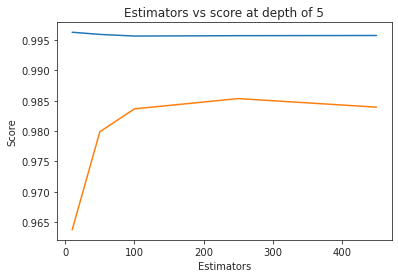

In [113]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9949106120213137 test Score 0.9893385073910347
depth =  9 Train Score 0.9964190597787597 test Score 0.9790121956160609
depth =  11 Train Score 0.9964289989227147 test Score 0.9829872252830417
depth =  15 Train Score 0.9965284012689292 test Score 0.9768084155801957
depth =  20 Train Score 0.9965284012689292 test Score 0.9766837273539686
depth =  35 Train Score 0.9965284012689292 test Score 0.9766837273539686
depth =  50 Train Score 0.9965284012689292 test Score 0.9766837273539686
depth =  70 Train Score 0.9965284012689292 test Score 0.9766837273539686
depth =  130 Train Score 0.9965284012689292 test Score 0.9766837273539686


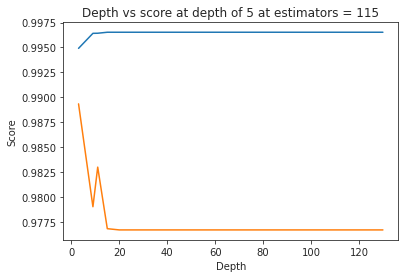

In [114]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [136]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])

mean test scores [0.99639931 0.99730465 0.99620056 0.99635956 0.99744405]


In [116]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [117]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [118]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [119]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.997682919521403
Test f1 score 0.9436015969741542


In [122]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


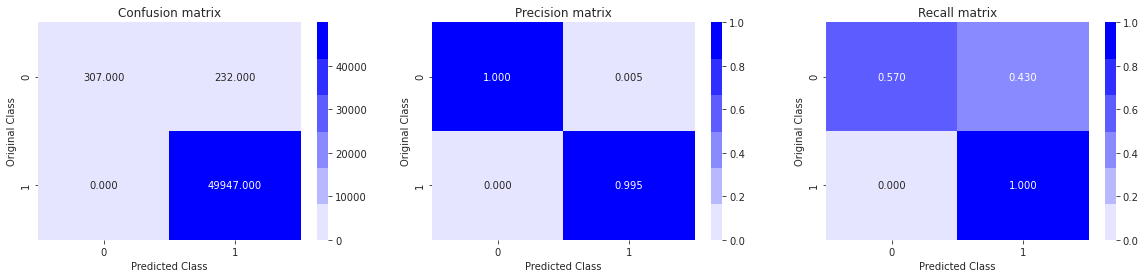

Test confusion_matrix


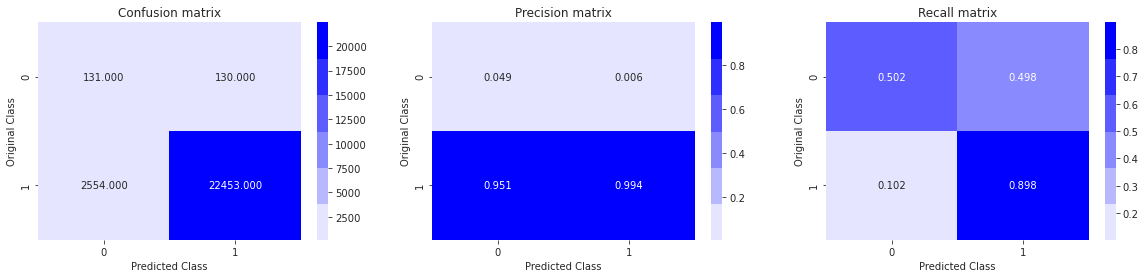

In [123]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

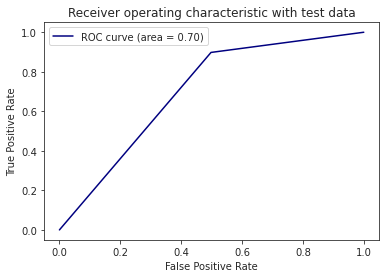

In [124]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

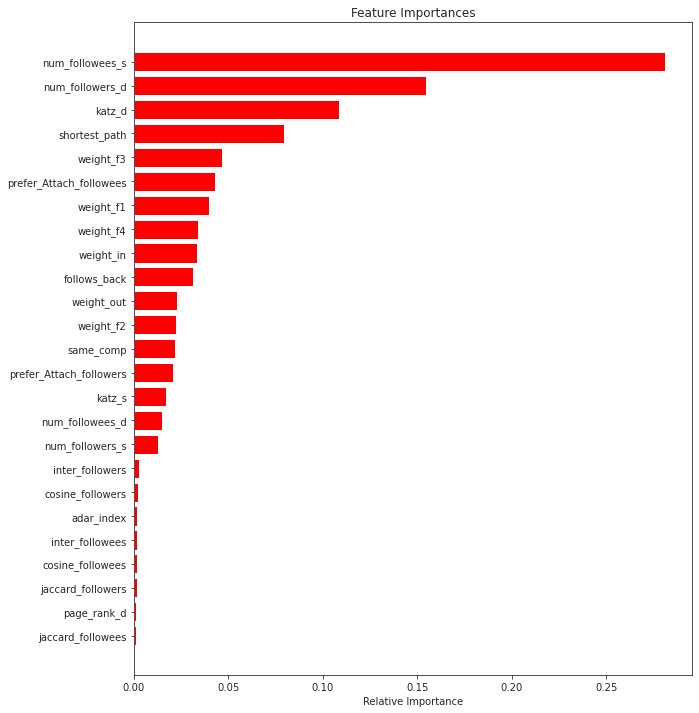

In [125]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [135]:
import xgboost as xgb
clf = xgb.XGBClassifier()
param_dist = {"n_estimators":sp_randint(90,115),
              "max_depth": sp_randint(5,15)
              }
model = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)


model.fit(df_final_train,y_train)
print('mean test scores',model.cv_results_['mean_test_score'])

mean test scores [0.99875013 0.99876008 0.99867019 0.99875013 0.99878011]


In [127]:
print(model.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=91, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [128]:
clf=xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=1, missing=None, n_estimators=113,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [129]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

[14:33:31] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [130]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999899894889634
Test f1 score 0.9555291716136558


Train confusion_matrix


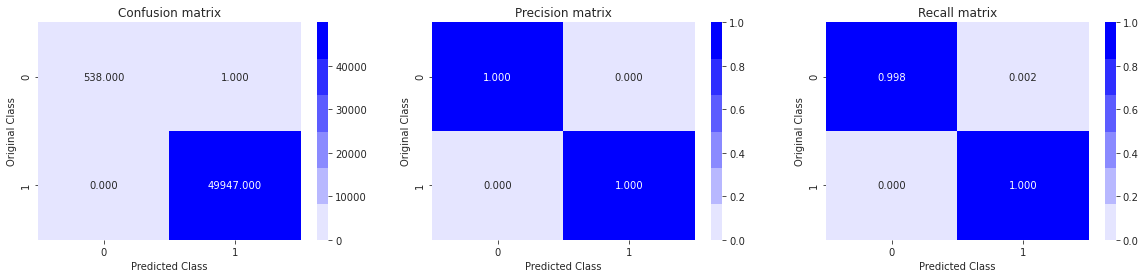

Test confusion_matrix


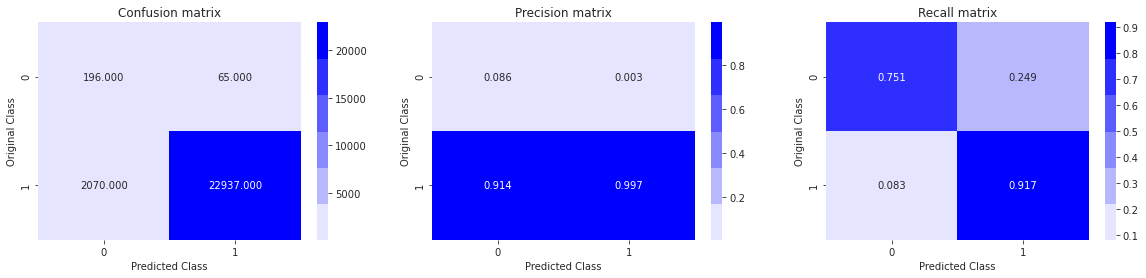

In [131]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

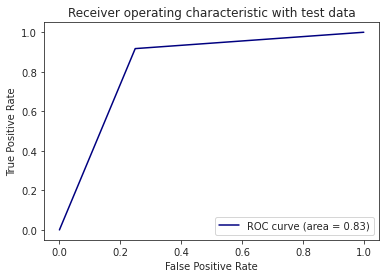

In [132]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()


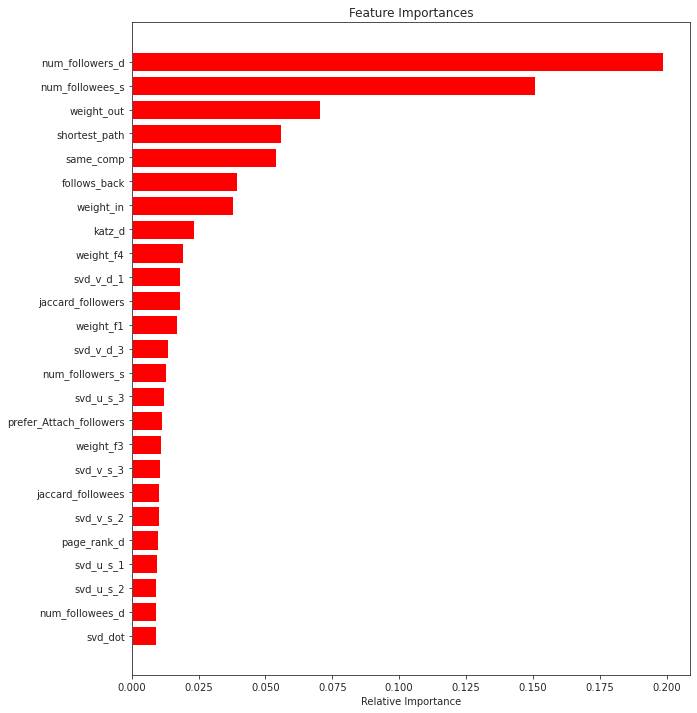

In [133]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [134]:
from prettytable import PrettyTable 
x = PrettyTable()
x.field_names = ["Model", "n_estimators", "max_depth", "Train f1-Score","Test f1-Score"]
x.add_row(['Random Forest','121','14','0.964','0.921'])
x.add_row(['XGBOOST','113','11','0.992','0.926'])
print(x)

+---------------+--------------+-----------+----------------+---------------+
|     Model     | n_estimators | max_depth | Train f1-Score | Test f1-Score |
+---------------+--------------+-----------+----------------+---------------+
| Random Forest |     121      |     14    |     0.964      |     0.921     |
|    XGBOOST    |     113      |     11    |     0.992      |     0.926     |
+---------------+--------------+-----------+----------------+---------------+



CONCLUSION

By performing this case study following observations were made:

1) Initially we have only a couple of features in our data set. First, we performed exploratory data analysis on our given data set such as the number of followers and followees of each person.

2) then after we generated some data points which were not present in our given data-set, since we had only class label 1 data.

3) We did some feature engineering on the dataset like finding the shortest path, Katz centrality, Jaccard distances, page rank, preferential attachments, etc.

4) After performing exploratory data analysis and feature engineering we split the whole dataset into train and test and performed random forest and XGBOOST taking f1-score as our metric.

5) At the end we plotted the confusion matrix and pretty-table for both algorithms and found the best hyperparameters.